In [13]:
"""
This Method imports a filelist of txt documents as dataframe
@param files: a list of files in txt format
@param de: boolean, if set True the language of the files is set german otherwise english
@return: dataframe that enlists the txtdocuments content sorted by job, company, job description, language
"""
def importAsDF(files, de):
    startdfs = [0 for x in range(len(files))]

    #import txt files as dataframes
    for i in range(len(files)):
        df= pd.read_csv(files[i], delimiter = "\t", header = None)
        startdfs[i]=df
    #create a more sorted df
    lang_dict = {}
    job_dict = {}
    company_dict = {}
    descr_dict = {}

    for j in range(len(startdfs)):
        #current df
        df = startdfs[j]
        #set language
        if de:
            lang ="de"
        else:
            lang= "en"
        lang_dict[j]= lang;
        #set job
        job = df.iloc[0,0]
        job_dict[j]= job
        #set company
        company = df.iloc[1,0]
        company_dict[j]= company;
        #set description - rest of the dataframe
        descr = ""
        for i in range(2,len(df.index)):
            descr = descr + " "+ df.iloc[i,0].strip("◾")
        descr_dict[j] = descr
    #convert dicts to series
    lang_series = pd.Series(lang_dict)
    job_series = pd.Series(job_dict)
    company_series = pd.Series(company_dict)
    descr_series = pd.Series(descr_dict)
    #convert series to df
    df = pd.DataFrame({'job':job_series, 'company':company_series, 'description':descr_series, 'language':lang_series,})
    return df

In [14]:

"""
This Method puts all jobdescriptions of a df into one string
@param df: The Job dataframe from which to take the descriptions from
@return: string filled with all job descriptions at once
"""
def getjobdescriptions(df):
    #get all descriptions
    descrstr = ""
    for i in range(len(df)):
        descrstr =descrstr +" "+ df.iloc[i,2]
    return (removespecials(descrstr))

In [15]:
"""
This Method puts all jobdescriptions of a df into one list of strings
@param df: The Job dataframe from which to take the descriptions from
@return: list of strings filled with all job descriptions doc by doc
"""
def getjobdescriptionsaslist(df):
    #get all descriptions
    descrstr = []
    for i in range(len(df)):
        newstr = removespecials(df.iloc[i,2].lower())
        descrstr += [newstr]
    return descrstr

In [16]:

"""
This Method removes specialcaracters
@param str: the string from whom those specialcharacters shall be removed
@return: string without those specialcaracters
"""
def removespecials(str):
    return str.replace("◾", "").replace("()", "").replace(")", "").replace("[", "").replace("]", "")

In [17]:
"""
This Method takes a string and returns a dataframe with counted occurence of propernouns. It detects compound nouns and counts them as those compound nouns but not as single nouns
@param str: the string win which to found nouns
@param de:  boolean, if set True the language of the files is set german otherwise english
@return: dataframe of single proper nouns and compound proper nouns and their count
"""
def spacy(descrstr, de):
    #let the spacy magic begin ^^
    import spacy
    from spacy.tokens import Doc
    from spacy.lang.de import German
    from spacy.lang.en import English
    if(de):
        nlp = spacy.load("de_core_news_sm")
    else:
        nlp = spacy.load("en_core_web_sm") #TODO: find english pack
    doc = nlp(descrstr)

    #Matching
    from spacy.matcher import Matcher

    #get compound proper nouns
    matcher = Matcher(nlp.vocab)
    pattern = [{"POS": "PROPN"}, {"POS": "PROPN"}]
    matcher.add("pat", [pattern])
    matches = matcher(doc)

    results =  [doc[start:end].text for match_id, start, end in matches]
    
    #put compound proper nouns nouns in dict and count them
    pnounscount = {}
    pnouns = {}
    index = []
    for result in results:
            if result in pnounscount:
                pnounscount[result] = pnounscount[result]+1
            else:
                pnounscount[result] = 1
                pnouns[result] = result
                index +=[result]
                
    #get single proper nouns (matcher seems to not have the functionallity to exclude the ones already counted in the double ones) 
    for i in range(len(doc)):
        token = doc[i]
        addtoken = False
        #first Token has only a right neighbor
        if i == 0:
            rNbor = token.nbor(1)
            if token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
                addtoken = True
        #last Token has only a left neighbor
        elif i == len(doc) -1:
            lNbor = token.nbor(-1)
            if lNbor.pos_ != 'PROPN'and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN':
                addtoken = True
        #default Tokens have a right and a left neighbor
        else:
            rNbor = token.nbor(1)
            lNbor = token.nbor(-1)
            if lNbor.pos_ != 'PROPN' and lNbor.pos_ != 'NOUN' and token.pos_ == 'PROPN' and rNbor.pos_ != 'PROPN' and rNbor.pos_ != 'NOUN':
                addtoken = True

        if addtoken:
            if token.text in pnounscount:
                pnounscount[token.text] = pnounscount[token.text]+1
            else:
                pnounscount[token.text] = 1
                pnouns[token.text] = token.text
                index +=[token.text]
            addtoken = False
    
    #convert to series and dataframe, sort by count column descending
    pncount = pd.Series(pnounscount)
    pn = pd.Series(pnouns)
    df = pd.DataFrame({'count':pncount, 'term':pn}, index = index)
    df = df.sort_values(by = 'count', ascending = False)
            
    return df

In [18]:
"""
This Method plots a dataframe of proper nouns and their counts in a bar diagram
@param df: dataframe to plot
"""
def plot(df):
    #Plot 
    import matplotlib.pyplot as plt
    plt.figure()
    plt.ylabel('Anzahl der Nennungen')
    plt.xlabel('Begriff')
    df['count'].plot(kind='bar')

In [19]:
"""
This Method uses other methods to take a list of txt files and convert it into a dataframe with proper nouns and their count within those strings
@param files: a filelist of txt files
@param de: boolean, true -> german , false -> english
@return: dataframe that contains propernouns and their count
"""
def getDF(files, de): 
    df1 = importAsDF(files,de)
    descr = getjobdescriptions(df1)
    #descr String nicht lower, replace 3 hauptjob in Beschreibungsstrings
    df = spacy(descr, de)
    return df

In [101]:
def dropthings(df):
    
    #get all companys
    df11 = importAsDF(files,True)
    comp = ""
    for i in range(len(df11)):    
        comp = comp +" "+ (df11.iloc[i,1])
        
    droplist = comp.split(" ")
    droplist += ['d','R','Data Engineer','Data Analyst','Data Scientist']
    
    for i in range(len(droplist)):
        if droplist[i] in df.index:
            df = df.drop(droplist[i])
    return df

In [108]:
"""
Read txt files, count proper nouns (compound proper nouns as well and those compounds explicitly not as single nouns)
Get Dataframe of those nouns and ther count and plot them
"""

#find files
import pandas as pd
import glob

files = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs DE\*.txt")
df = getDF(files, True)
df = dropthings(df)

filesen = glob.glob(r"C:\Users\thegy\Documents\Studium\HS FL 4\Mining\Jobs EN\*.txt")
dfen = getDF(filesen, False)
dfen = dropthings(dfen)

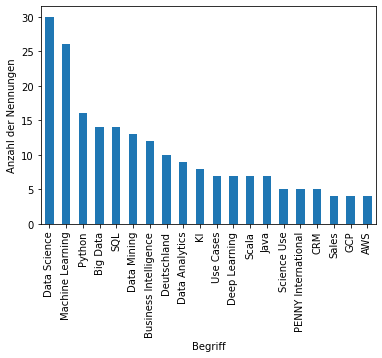

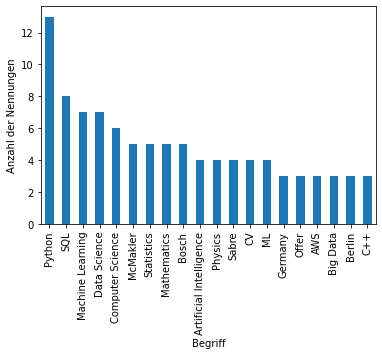

In [111]:
plot(df[:20])
plot(dfen[:20])

In [85]:
"""
This Method compares vector similarity within a term-document-matrix using cosine simularitys
@param vec: term-document-matrix
@param doc0: Documentvector
@param doc1: Documentvector
@return: a value between 0 and 1, whereas 0 means no similarity and 1 means equality
"""
def cossim(vec, doc0, doc1):    
    #Ähnlichkeiten zwischen 2 Dokumenten
    from sklearn.metrics.pairwise import cosine_similarity
    vec1 = np.array(vec[doc0].toarray())
    vec2 = np.array(vec[doc1].toarray())
    sim = (cosine_similarity(vec1, vec2))
    return sim

In [86]:

"""
This Method builds a term-term matrix 
@param vector: term-document-matrix
@return: a term-term-matrix
"""
def ttm(vector):   
    #similaritys between terms in a matrix
    from sklearn.metrics.pairwise import cosine_similarity
    vec = vector.toarray()
    vec = vec.transpose()
    
    #the Terms axis is 0
    dim0 = vec.shape[0]
    termtermmat = np.empty([dim0,dim0]) 

    for x in range(dim0):
        for y in range(dim0):
            termtermmat[x,y]= cosine_similarity([vec[x]],[vec[y]])

    return termtermmat

In [87]:
"""
This Method gets all terms out of a dataframe and returns them as a string list
@param df: the dataframe from which the terms shall be selected
@return: stringlist with all terms of that dataframe
"""
def getterms(df):
    terms = []
    for i in range(len(df)):
        terms += [df.iloc[i,1].lower()]
    return terms

In [88]:
"""
This Method eliminates all whitespaces out of a textlist
@param textlist: tlist with strings with too many whitespaces
@return: stringlist without whitespaces within those string
"""
def nowhitespace(textlist):
    for i in range(len(textlist)):
        textlist[i] = textlist[i].replace(" ", "")
    return textlist

In [89]:

"""
This Method replaces terms with spaces with terms without spaces and vice versa
(Needed, to count compound propernuns as one noun)
@param docs: document list /string list)
@param termsorg: (stringlist) terms in ther original form
@param terms: (stringlist) terms in the form the originals shall be replaced
@return: documentlist with switched up terms
"""
def replacespace(docs, termsorg,terms):
    for i in range(len(docs)):
        for t in range(len(terms)):
            docs[i] = docs[i].replace(termsorg[t].lower(), terms[t].lower())
            #print(i, termsorg[t].lower(),terms[t].lower() )
    return(docs)

In [90]:
"""
Get nterms of dataframe with proper nouns
Compile them into term-document-matrixes
Compare Docs similaritys with cosine simularity
Create Term-Term-Matrix with term simularitys
"""
import numpy as np

nterms = 30
#to have that exact number

#ged rid of those whitespaces between compound nouns, because otherwise those compound nouns would have been counted as 2 single words
termsorg = getterms(df[:nterms])
terms = nowhitespace(termsorg.copy())

df1 = importAsDF(files,True)
docs = getjobdescriptionsaslist(df1)
docs
#get rid of whitespaces in those terms within the docs
docs = replacespace(docs, termsorg,terms)

#print(text)

In [91]:

#get Count-Vectorizer - Term-Document-Matrix
from sklearn.feature_extraction.text import CountVectorizer
cvectorizer = CountVectorizer()
cvectorizer.fit(terms)
cvocab = cvectorizer.vocabulary_
cvec = cvectorizer.transform(docs)

#get Tfidf-Vectorizer - Term-Document-Matrix
from sklearn.feature_extraction.text import TfidfVectorizer
tvectorizer = TfidfVectorizer()
tvectorizer.fit(terms)
tvocab = tvectorizer.vocabulary_
tvec = tvectorizer.transform(docs)

In [92]:
#compare docs
doc0 = 1
doc1 = 10
sim0 = cossim(cvec,doc0,doc1)
sim1 = cossim(tvec,doc0,doc1)
print(sim0,sim1)

[[0.]] [[0.]]


In [93]:
#compare terms in a term-term-matrix
tttm = ttm(tvec)

In [94]:
#Allocate columns to terms
name = tvectorizer.get_feature_names()
name = replacespace(name, terms, termsorg)

dfmat ={}
for i in range(len(name)):
    dfmat[name[i]]=tttm[i]

ttdf = pd.DataFrame(dfmat, index = name)
print(ttdf)

                            aws  big data  business intelligence       crm  \
aws                    1.000000  0.152730               0.000000  0.090410   
big data               0.152730  1.000000               0.285508  0.143950   
business intelligence  0.000000  0.285508               1.000000  0.171411   
crm                    0.090410  0.143950               0.171411  1.000000   
data analytics         0.107224  0.166694               0.103668  0.030932   
data lake              0.181932  0.066847               0.218827  0.000000   
data mining            0.073022  0.229937               0.060496  0.102601   
data science           0.162100  0.307843               0.195622  0.123505   
data warehouse         0.000000  0.071621               0.570197  0.101250   
deep learning          0.046965  0.000000               0.000000  0.000000   
deutschland            0.000000  0.065377               0.281599  0.068589   
gcp                    0.693672  0.136410               0.000000